In [1]:
from preprocessing import apply_OHE, init_OHE, feature_engineering, reduce_by_frequency_occurrence

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import numpy as np
import pandas as pd
import auxiliar as aux

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.metrics import roc_auc_score

<h1>Boosting</h1>

<h3> Preprocesamiento 1: OHE</h3>

In [2]:
X, y = aux.get_train_set()
X = feature_engineering(X)

In [3]:
init_OHE(X)
X_p1 = apply_OHE(X)
X_p1

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,barrio_almagro,barrio_balvanera,barrio_barracas,barrio_belgrano,barrio_boedo,barrio_caballito,...,trabajo_no_especificado,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,17,39,2174,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17,50,0,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,38,0,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,53,0,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,28,0,40,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,27,0,38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,13,40,0,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32558,13,58,0,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32559,13,22,0,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X_train_p1, X_test_p1, y_train_p1, y_test_p1 = train_test_split(
    X_p1, y, random_state=0, test_size=0.2, stratify=y
)

In [6]:
#'criterion': ['gini', 'entropy'], 'max_depth': np.arange(5, 6), 'min_samples_leaf': np.arange(35, 46), 'n_estimators': np.arange(1, 1001, 10), 'max_features': ['sqrt']

parameters = {'max_depth': np.arange(5, 16, 5), 'min_samples_leaf': np.arange(50, 151, 50),'n_estimators': np.arange(100,301,100),
              'max_features': ['sqrt', 'log2'], 'loss':['deviance', 'exponential'], 'learning_rate': np.array([0.1, 0.01])}

clf = GradientBoostingClassifier(random_state = 0)

scv_p1 = RandomizedSearchCV(
    clf,  parameters, n_iter=50, scoring='roc_auc', cv=5, return_train_score=True,
).fit(X_train_p1, y_train_p1)

In [7]:
print(f"Best score: {scv_p1.best_score_}")
print(f"Best params {scv_p1.best_params_}")
print("------------------")
print(f"Score in Validation: {scv_p1.score(X_test_p1, y_test_p1)}")

Best score: 0.9225562347661116
Best params {'n_estimators': 300, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 10, 'loss': 'deviance', 'learning_rate': 0.1}
------------------
Score in Validation: 0.9216745166216133


In [8]:
model_boosting_p1 = scv_p1.best_estimator_
model_boosting_p1

GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                           min_samples_leaf=100, n_estimators=300,
                           random_state=0)

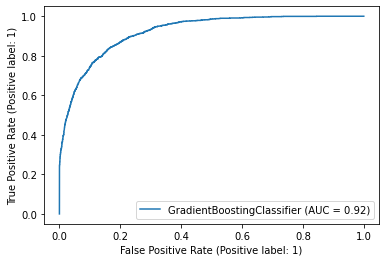

In [9]:
plot_roc_curve(model_boosting_p1, X_test_p1, y_test_p1, response_method="predict_proba")
plt.show()

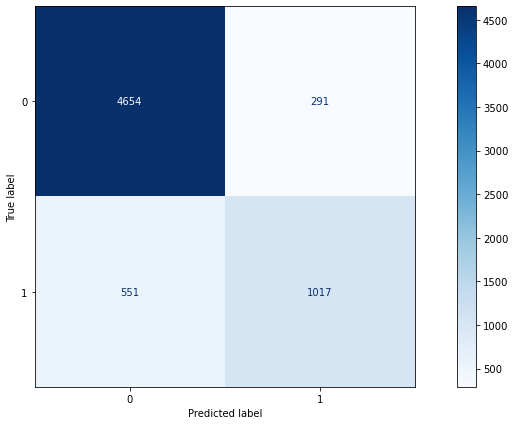

In [10]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    model_boosting_p1, X_test_p1, y_test_p1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax
)
plt.show()

In [11]:
y_pred_p1 = model_boosting_p1.predict(X_test_p1)
print(classification_report(y_test_p1, y_pred_p1))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4945
           1       0.78      0.65      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513



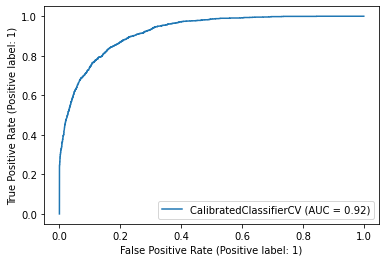

test score: 0.8696453247351451


In [13]:
calibrated_clf_p1 = CalibratedClassifierCV(base_estimator=model_boosting_p1, cv="prefit")
calibrated_clf_p1.fit(X_test_p1, y_test_p1)
plot_roc_curve(calibrated_clf_p1, X_test_p1, y_test_p1, response_method="predict_proba")
plt.show()
print(f"test score: {calibrated_clf_p1.score(X_test_p1, y_test_p1)}")

<h3> Preprocesamiento 2: OHE y Reducción de las columnas: Barrio, Religion, Categoria de Trabajo, Estado Marital </h3>

In [14]:
X_p2 = reduce_by_frequency_occurrence(X)

In [15]:
init_OHE(X_p2)
X_p2 = apply_OHE(X_p2)
X_p2

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,barrio_palermo,categoria_de_trabajo_relacion_de_dependencia,estado_marital_otro,estado_marital_sin_matrimonio,genero_mujer,religion_judaismo,...,trabajo_no_especificado,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,17,39,2174,40,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17,50,0,13,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,38,0,40,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,53,0,40,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,28,0,40,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,27,0,38,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,13,40,0,40,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32558,13,58,0,40,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32559,13,22,0,20,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(
    X_p2, y, random_state=0, test_size=0.2, stratify=y
)

In [17]:
#'criterion': ['gini', 'entropy'], 'max_depth': np.arange(5, 6), 'min_samples_leaf': np.arange(35, 46), 'n_estimators': np.arange(1, 1001, 10), 'max_features': ['sqrt']

parameters = {'max_depth': np.arange(5, 16, 5), 'min_samples_leaf': np.arange(50, 151, 50),'n_estimators': np.arange(100,301,100),
              'max_features': ['sqrt', 'log2'], 'loss':['deviance', 'exponential'], 'learning_rate': np.array([0.1, 0.01])}

clf = GradientBoostingClassifier(random_state = 0)

scv_p2 = RandomizedSearchCV(
    clf,  parameters, n_iter=50, scoring='roc_auc', cv=5, return_train_score=True,
).fit(X_train_p2, y_train_p2)

In [18]:
print(f"Best score: {scv_p2.best_score_}")
print(f"Best params {scv_p2.best_params_}")
print("------------------")
print(f"Score in Validation: {scv_p2.score(X_test_p2, y_test_p2)}")

Best score: 0.9237087288612532
Best params {'n_estimators': 300, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.1}
------------------
Score in Validation: 0.9212691004106395


In [19]:
model_boosting_p2 = scv_p2.best_estimator_
model_boosting_p2

GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                           min_samples_leaf=50, n_estimators=300,
                           random_state=0)

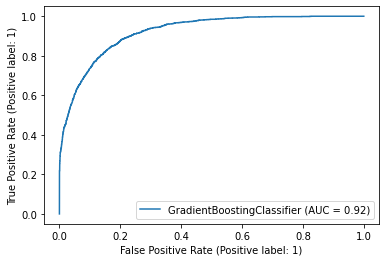

In [20]:
plot_roc_curve(model_boosting_p2, X_test_p2, y_test_p2, response_method="predict_proba")
plt.show()

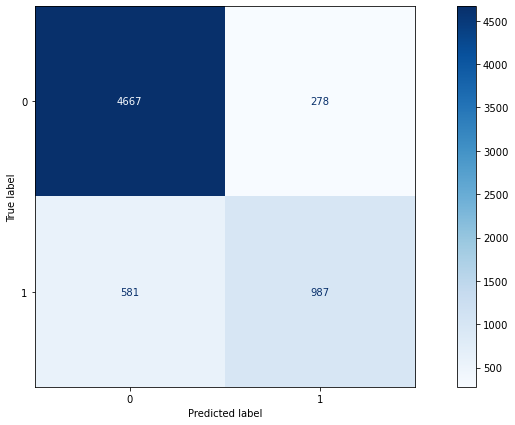

In [21]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    model_boosting_p2, X_test_p2, y_test_p2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax
)
plt.show()

In [22]:
y_pred_p2 = model_boosting_p2.predict(X_test_p2)
print(classification_report(y_test_p2, y_pred_p2))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4945
           1       0.78      0.63      0.70      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.86      0.87      0.86      6513



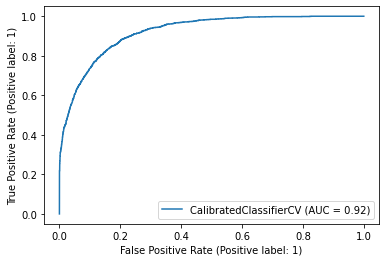

test score: 0.8678028558268079


In [24]:
calibrated_clf_p2 = CalibratedClassifierCV(base_estimator=model_boosting_p2, cv="prefit")
calibrated_clf_p2.fit(X_test_p2, y_test_p2)
plot_roc_curve(calibrated_clf_p2, X_test_p2, y_test_p2, response_method="predict_proba")
plt.show()
print(f"test score: {calibrated_clf_p2.score(X_test_p2, y_test_p2)}")